# Classification Images

In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random,os
from keras.preprocessing.image import load_img


Training Data

In [23]:
train_data=os.listdir('/content/drive/MyDrive/cats&dogs/training')

preprocessing Data

In [24]:
len(train_data)

1000

split data

In [25]:
categories=[]
for i in train_data:
  if i.split('.')[0]=='dog':
    categories.append(0)
  else:
    categories.append(1)

In [26]:
df = pd.DataFrame({
    'image_name': train_data,
    'category': categories
})

In [27]:
df.tail()

,image_name,category
995,dog.4327.jpg,0
996,dog.4492.jpg,0
997,dog.4457.jpg,0
998,dog.4332.jpg,0
999,dog.4284.jpg,0


In [28]:
df.head()

,image_name,category
0,cat.4003.jpg,1
1,cat.4014.jpg,1
2,cat.4006.jpg,1
3,cat.4010.jpg,1
4,cat.4011.jpg,1


<Axes: xlabel='category'>

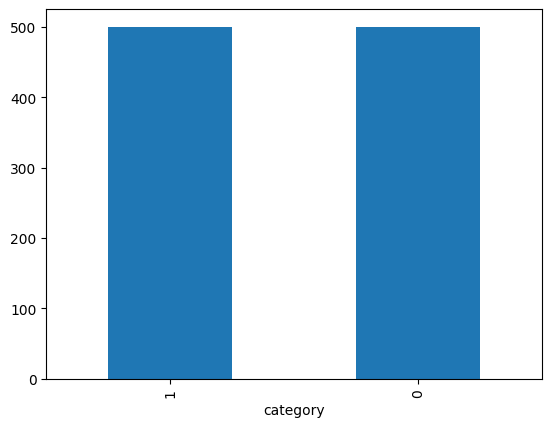

In [29]:
df['category'].value_counts().plot.bar()

Show sample of images randomly

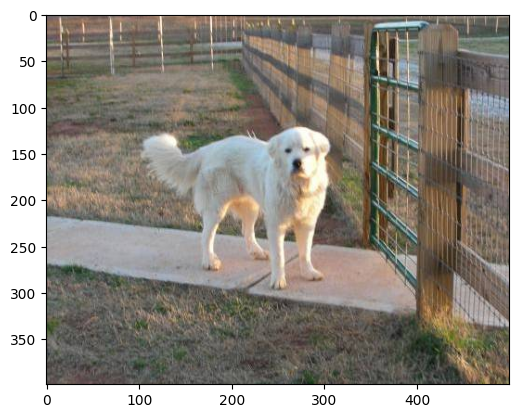

In [30]:
sample = random.choice(train_data)
image_path = '/content/drive/MyDrive/cats&dogs/training/' + sample
image = load_img(image_path)
plt.imshow(image)

split traing data to traing and validate to test during training

In [54]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [53]:
df["category"] = df["category"].replace({1: 'cat', 0: 'dog'})

In [31]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Build Model

In [51]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# using dropout to prevent overfit if not use in this model model overfitting and not work well in test data
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dense(64, activation='sigmoid'))
# used softmax in output layer
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [52]:
# used EarlyStopping and ReduceLROnPlateau to prevent overfitting
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)
callbacks = [earlystop,learning_rate_reduction]

Data Augmentation

In [55]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [56]:
#open data frame to apply AUG
train_generator = train_datagen.flow_from_dataframe(
    train_df, "/content/drive/MyDrive/cats&dogs/training",
    x_col='image_name',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=20
)

Found 800 validated image filenames belonging to 2 classes.


In [57]:
# AUG on validation rescale only
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,"/content/drive/MyDrive/cats&dogs/training",
    x_col='image_name',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=15
)

Found 200 validated image filenames belonging to 2 classes.


show image after Augmentation on it

In [72]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, "/content/drive/MyDrive/cats&dogs/training",
    x_col='image_name',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


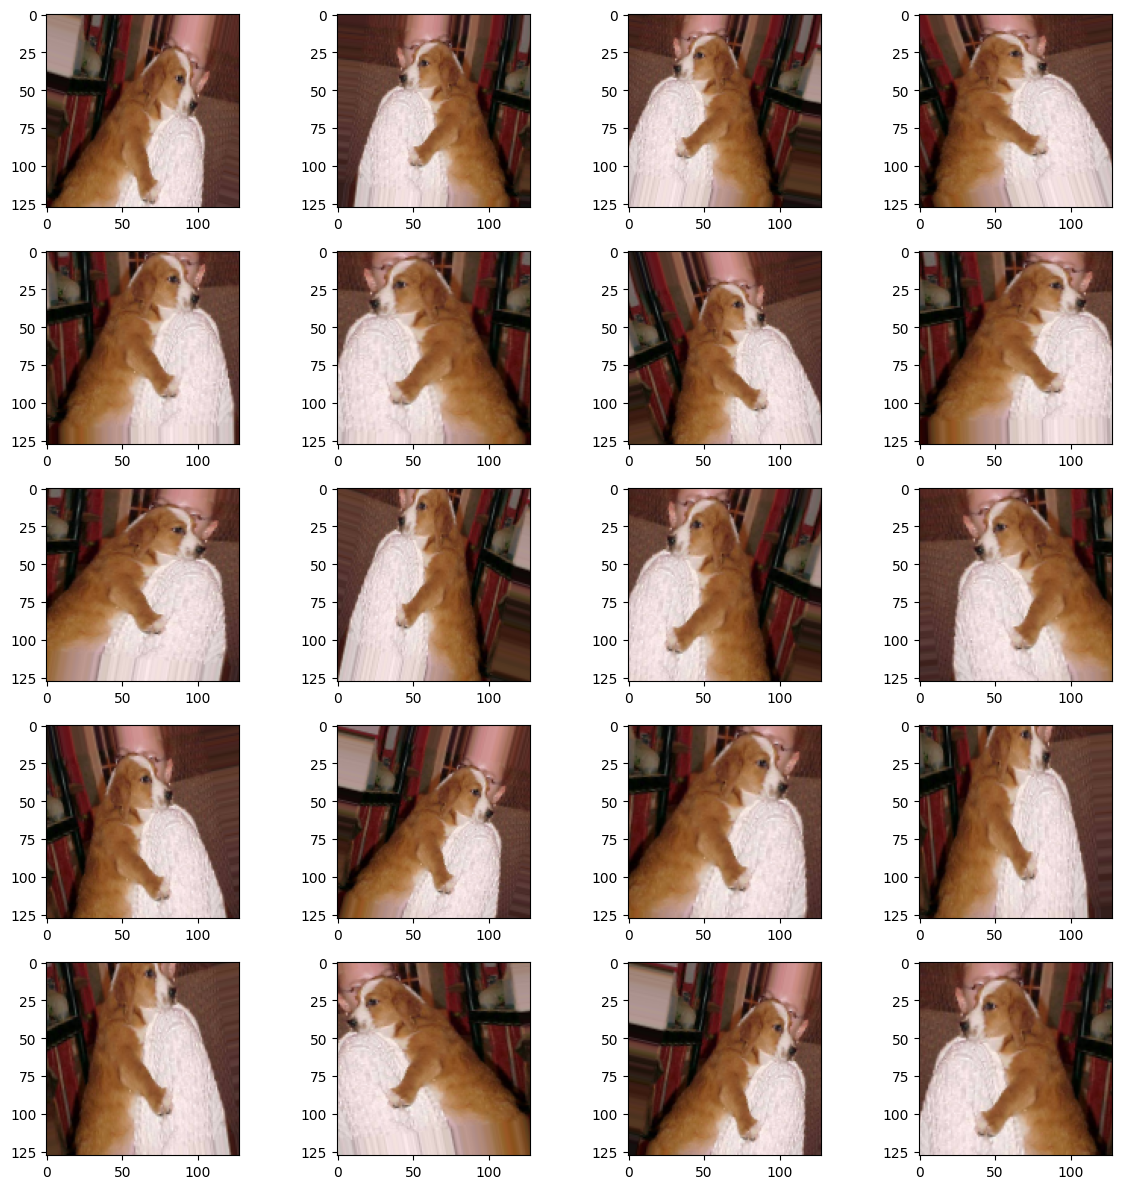

In [73]:
plt.figure(figsize=(12, 12))
for i in range(0, 20):
    plt.subplot(5,4, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [60]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Fit model

In [61]:
epochs=20
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,

    callbacks=callbacks
)

<ipython-input-61-845f81f3bd07>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.5900

40/40 [==============================] - 59s 1s/step - loss: 0.6999 - accuracy: 0.5900 - val_loss: 0.9685 - val_accuracy: 0.4872 - lr: 0.0010
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.6450

40/40 [==============================] - 58s 1s/step - loss: 0.6312 - accuracy: 0.6450 - val_loss: 0.8820 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.6538

40/40 [==============================] - 54s 1s/step - loss: 0.6106 - accuracy: 0.6538 - val_loss: 0.8601 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 4/20
40/40 [==============================] - ETA: 0s - loss: 0.5973 - accuracy: 0.6787

40/40 [==============================] - 57s 1s/step - loss: 0.5973 - accuracy: 0.6787 - val_loss: 0.7436 - val_accuracy: 0.4769 - lr: 0.0010
Epoch 5/20
40/40 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7063

40/40 [==============================] - 55s 1s/step - loss: 0.5631 - accuracy: 0.7063 - val_loss: 1.0789 - val_accuracy: 0.4769 - lr: 0.0010
Epoch 6/20
40/40 [==============================] - ETA: 0s - loss: 0.5725 - accuracy: 0.6888

40/40 [==============================] - 53s 1s/step - loss: 0.5725 - accuracy: 0.6888 - val_loss: 0.9505 - val_accuracy: 0.4872 - lr: 0.0010
Epoch 7/20
40/40 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.7138

40/40 [==============================] - 55s 1s/step - loss: 0.5504 - accuracy: 0.7138 - val_loss: 0.7254 - val_accuracy: 0.5436 - lr: 0.0010
Epoch 8/20
40/40 [==============================] - ETA: 0s - loss: 0.5701 - accuracy: 0.7088

40/40 [==============================] - 53s 1s/step - loss: 0.5701 - accuracy: 0.7088 - val_loss: 0.9435 - val_accuracy: 0.4872 - lr: 0.0010
Epoch 9/20
40/40 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.7287

40/40 [==============================] - 54s 1s/step - loss: 0.5417 - accuracy: 0.7287 - val_loss: 0.7680 - val_accuracy: 0.5846 - lr: 0.0010
Epoch 10/20
40/40 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.7150

40/40 [==============================] - 55s 1s/step - loss: 0.5458 - accuracy: 0.7150 - val_loss: 0.9964 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 11/20
40/40 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7175

40/40 [==============================] - 55s 1s/step - loss: 0.5645 - accuracy: 0.7175 - val_loss: 1.0470 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 12/20
40/40 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.7275

40/40 [==============================] - 54s 1s/step - loss: 0.5334 - accuracy: 0.7275 - val_loss: 0.9045 - val_accuracy: 0.5128 - lr: 0.0010
Epoch 13/20
40/40 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7300

40/40 [==============================] - 55s 1s/step - loss: 0.5275 - accuracy: 0.7300 - val_loss: 0.8108 - val_accuracy: 0.5282 - lr: 0.0010
Epoch 14/20
40/40 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.6925

40/40 [==============================] - 55s 1s/step - loss: 0.5489 - accuracy: 0.6925 - val_loss: 0.7621 - val_accuracy: 0.5846 - lr: 0.0010
Epoch 15/20
40/40 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.7337

40/40 [==============================] - 53s 1s/step - loss: 0.5328 - accuracy: 0.7337 - val_loss: 0.7228 - val_accuracy: 0.5590 - lr: 0.0010
Epoch 16/20
40/40 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.7525

40/40 [==============================] - 54s 1s/step - loss: 0.5105 - accuracy: 0.7525 - val_loss: 0.6114 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 17/20
40/40 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.7750

40/40 [==============================] - 54s 1s/step - loss: 0.4724 - accuracy: 0.7750 - val_loss: 0.6179 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 18/20
40/40 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.7800

40/40 [==============================] - 53s 1s/step - loss: 0.4803 - accuracy: 0.7800 - val_loss: 0.6163 - val_accuracy: 0.6256 - lr: 0.0010
Epoch 19/20
40/40 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.7738

40/40 [==============================] - 60s 1s/step - loss: 0.4843 - accuracy: 0.7738 - val_loss: 0.6398 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 20/20
40/40 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.7837

40/40 [==============================] - 54s 1s/step - loss: 0.4569 - accuracy: 0.7837 - val_loss: 0.5139 - val_accuracy: 0.7385 - lr: 0.0010


Test Data

In [62]:
test_images = os.listdir("/content/drive/MyDrive/cats&dogs/testing")
test_df = pd.DataFrame({
    'filename': test_images
})
nb_samples = test_df.shape[0]
nb_samples

200

In [63]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,"/content/drive/MyDrive/cats&dogs/testing",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 200 validated image filenames.


In [64]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-64-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [65]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)


In [66]:
test_df['label'] = test_df['filename'].apply(lambda x : 'cat' if 'cat' in x else 'dog')

In [67]:
test_df['category'].value_counts()

category
cat    100
dog    100
Name: count, dtype: int64

In [68]:
test_df['label'].value_counts()

label
cat    100
dog    100
Name: count, dtype: int64

predicted data

In [69]:
test_df

,filename,category,label
0,cat.4501.jpg,cat,cat
1,cat.4505.jpg,cat,cat
2,cat.4495.jpg,cat,cat
3,cat.4496.jpg,cat,cat
4,cat.4499.jpg,dog,cat
...,...,...,...
195,dog.4896.jpg,dog,dog
196,dog.4978.jpg,dog,dog
197,dog.4905.jpg,dog,dog
198,dog.4964.jpg,dog,dog


In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

CM = confusion_matrix(test_df['label'], test_df['category'])
print('Confusion Matrix is : \n', CM)

Confusion Matrix is : 
 [[76 24]
 [24 76]]


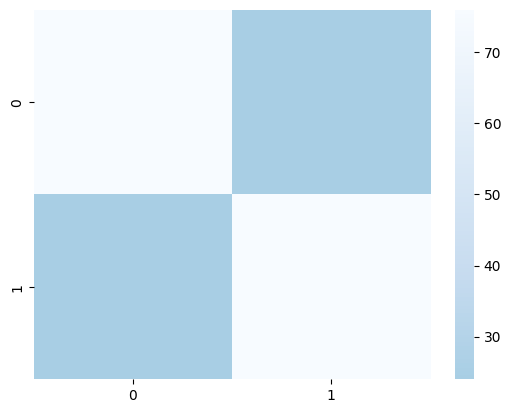

In [75]:
# drawing confusion matrix
sns.heatmap(CM, center = True,cmap='Blues_r')
plt.show()